## Deep learing project no.1

Marek Szydłowski 136633 <br>
Wotjek Tomczak 145467

In [284]:
import os
import fnmatch
import webbrowser
from pathlib import Path

from IPython.display import display

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models


In [285]:
DATA_PATH = "data/256_ObjectCategories/"


In [286]:
# cheking size of classes in our database of choice

file_counter = []

for data_dir in Path(DATA_PATH).iterdir():
    file_counter.append(
        [
            len(fnmatch.filter(os.listdir(data_dir), "*.jpg")),
            str(data_dir).split("/")[-1],
        ]
    )

results = pd.DataFrame(
    sorted(file_counter, key=lambda x: x[0], reverse=True),
    columns=["FILE COUNT", "CLASS NAME"],
)

results


,FILE COUNT,CLASS NAME
0,827,257.clutter
1,800,251.airplanes-101
2,798,145.motorbikes-101
3,435,253.faces-easy-101
4,358,232.t-shirt
...,...,...
252,80,179.scorpion-101
253,80,086.golden-gate-bridge
254,80,204.sunflower-101
255,80,099.harpsichord


In [287]:
data_check = Path(DATA_PATH)

if not data_check.exists():
    print(
        "Please download the data first and place it unzipped in data folder which will be placed in root of project file"
    )
    _ = webbrowser.open(
        "https://drive.google.com/u/0/uc?id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK&export=download"
    )


In [288]:
img = cv2.imread(DATA_PATH + "105.horse/105_0260.jpg")
img.shape


(500, 375, 3)

In [289]:
# animal kingdom here we come
animal_codes = np.array(
    [
        "007",
        "009",
        "024",
        "028",
        "034",
        "038",
        "040",
        "049",
        "052",
        "056",
        "057",
        "060",
        "064",
        "065",
        "080",
        "084",
        "085",
        "087",
        "089",
        "090",
        "093",
        "100",
        "105",
        "106",
        "111",
        "113",
        "114",
        "116",
        "121",
        "124",
        "129",
        "134",
        "150",
        "151",
        "152",
        "158",
        "164",
        "166",
        "168",
        "179",
        "186",
        "189",
        "190",
        "198",
        "201",
        "207",
        "228",
        "236",
        "250",
        "254",
        "256",
    ]
)

# real american values
america_codes = np.array(
    [
        "001",
        "002",
        "003",
        "014",
        "029",
        "032",
        "042",
        "050",
        "051",
        "095",
        "102",
        "104",
        "108",
        "119",
        "125",
        "172",
        "173",
        "178",
        "176",
        "205",
        "208",
        "209",
        "210",
        "222",
    ]
)


In [290]:
np.random.seed(2137)
random_ids = np.random.choice([str(i).zfill(3) for i in range(258)], 20, replace=False)


In [291]:
images = {}
for data_dir in Path(DATA_PATH).iterdir():
    num, _ = data_dir.name.split(".")
    if num in random_ids:
        for f in data_dir.iterdir():
            if not f.is_file():
                continue

            if data_dir.name not in images:
                images[data_dir.name] = 1
            else:
                images[data_dir.name] += 1

ddf = (
    pd.DataFrame.from_dict(images, "index")
    .reset_index()
    .rename({0: "length", "index": "name"}, axis=1)
)


In [292]:
print(f"Number of chosen classes before balancing: {len(ddf)}")


Number of chosen classes before balancing: 20


In [293]:
ddf = ddf[ddf["length"].apply(lambda x: False if x < 80 else True)]

ddf.loc[:, "label"] = ddf["name"].apply(lambda x: x.split(".")[0])

ddf = ddf.sort_values(by="length", ascending=False).reset_index(drop=True)


In [294]:
print(
    f"Number of classes after primary balancing (removing classes that have less than 80 images): {len(ddf)}"
)


Number of classes after primary balancing (removing classes that have less than 80 images): 20


In [295]:
ddf.head()


,name,length,label
0,193.soccer-ball,174,193
1,214.teepee,139,214
2,043.coin,124,043
3,141.microscope,117,141
4,208.swiss-army-knife,109,208


In [296]:
df = ddf.sample(20).reset_index(drop=True)


In [297]:
dataset = []
labels = []
filenames = []

for row in df.itertuples():
    dirname = row.name
    label = row.label

    no_files = 0
    for filename in os.listdir(DATA_PATH + dirname):
        if no_files == 80:
            break

        if ".jpg" not in filename:
            continue

        filenames.append(dirname + "/" + filename)

        img = cv2.imread(DATA_PATH + dirname + "/" + filename)
        resized = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)

        dataset.append(resized)
        labels.append(label)

        no_files += 1

dataset = np.array(dataset)


In [298]:
dataset.shape


(1600, 32, 32, 3)

In [299]:
bgr_mean = np.mean(dataset, axis=(0, 1, 2))
bgr_std = np.std(dataset, axis=(0, 1, 2))
bgr_mean, bgr_std


(array([138.12008728, 143.60963745, 147.14764587]),
 array([80.45059566, 77.11481837, 78.14119908]))

In [300]:
std_data = (dataset - bgr_mean) / bgr_std
std_data.shape


(1600, 32, 32, 3)

Image before standardization


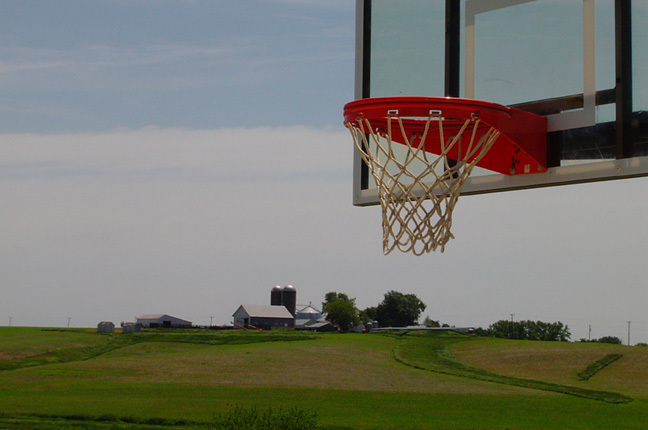

In [301]:
print('Image before standardization')
with Image.open(DATA_PATH + filenames[0]) as img:
    display(img)

In [302]:
# DO NOT CLOSE IMAGE WITH "X" ICON, JUST WAIT
# Uncoment to run


# cv2.imshow('tmp', std_data[0])
# cv2.waitKey(7000)

# cv2.destroyAllWindows()

In [303]:
# splitting data on train and test
X_train, X_test, y_train, y_test = train_test_split(
    std_data, labels, stratify=labels, test_size=0.3, random_state=23
)

y_train, y_test = np.array(y_train), np.array(y_test)


In [304]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1120, 32, 32, 3), (480, 32, 32, 3), (1120,), (480,))

In [305]:
def oneHotterEncoder(target):
    _target = target.reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown="ignore")
    new_target = encoder.fit(_target)
    return new_target.categories_, new_target.transform(_target).toarray()


In [306]:
classes_train, y_train_enc = oneHotterEncoder(y_train)
classes_test, y_test_enc = oneHotterEncoder(y_test)

(classes_train,) = classes_train
(classes_test,) = classes_test


In [307]:
classes_test

array(['006', '009', '031', '034', '043', '059', '112', '130', '139',
       '141', '142', '166', '174', '178', '180', '193', '197', '208',
       '214', '238'], dtype='<U3')

In [308]:
print(X_train.shape, y_train_enc.shape, X_test.shape, y_test_enc.shape)


(1120, 32, 32, 3) (1120, 20) (480, 32, 32, 3) (480, 20)


In [309]:
X_train[0].shape


(32, 32, 3)

In [ ]:
model = models.Sequential()

model.add(
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        input_shape=X_train[0].shape,
    )
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(.65)) # .75
model.add(layers.Dense(64))
model.add(layers.Dropout(.75)) # .65
model.add(layers.Dense(64))
model.add(layers.Dense(len(classes_train), activation="softmax"))

print(f"Number of classes: {len(classes_test)}")
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train,
    y_train_enc,
    batch_size=32,
    epochs=250,
    validation_data=(X_test, y_test_enc),
    callbacks=[early_stopping],
)


Number of classes: 20
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_173 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_144 (Ba  (None, 16, 16, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_174 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                                           
                               

In [ ]:
pred = model.predict(X_test[:20])
ids = np.argmax(pred, axis=1)


In [ ]:
np.sum(classes_test[ids] == y_test[: len(ids)]) / len(ids) * 100


40.0

In [ ]:
X_test.shape, y_test.shape


((480, 32, 32, 3), (480,))

In [ ]:
model.predict([X_test[:1]])


array([[6.4310527e-08, 3.1882981e-05, 1.7684352e-02, 3.0889285e-07,
        9.1432261e-01, 4.8780606e-07, 1.1851569e-06, 1.6241465e-08,
        1.4664262e-05, 1.1169597e-07, 6.4127602e-02, 9.4377003e-07,
        8.0454018e-04, 3.1308346e-07, 7.3970363e-10, 1.1244385e-06,
        2.6700900e-11, 6.2469988e-11, 1.2687406e-04, 2.8830038e-03]],
      dtype=float32)